In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
learn = tf.contrib.learn
slim = tf.contrib.slim

plt.ion()

print("TensorFlow {v}".format(v=tf.__version__))

TensorFlow 0.11.0rc2


## 線形回帰

[tf.contrib.learn.LinearRegressor](https://www.tensorflow.org/versions/master/api_docs/python/contrib.learn.html#LinearRegressor)を利用すれば済むが、後で拡張する関係でtf.contrib.slim.fully_connectedを使う。

Instructions for updating:
Use mean_squared_error.


Estimator(params=None)

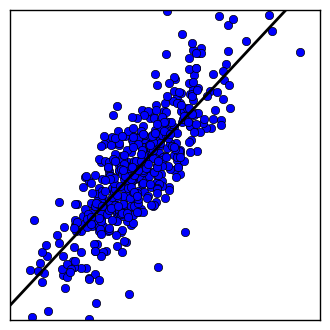

In [2]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, n_features=1, noise=25.0, random_state=12345)
X, y = X.astype(np.float32), y.astype(np.float32)

def my_model(X, y):
    y = tf.reshape(y, [-1, 1])
    prediction = slim.fully_connected(X, 1, activation_fn=None, scope='fc')
    loss = slim.losses.mean_squared_error(prediction, y)
    train_op = slim.optimize_loss(loss, slim.get_global_step(), learning_rate=0.01, optimizer='SGD')

    return tf.reshape(prediction, [-1]), loss, train_op

class MyMonitor(learn.monitors.BaseMonitor):

    def begin(self, max_steps):
        self.figure = plt.figure(figsize=(4, 4))
        self.x_min, self.x_max = X.min() - .5, X.max() + .5
        self.y_min, self.y_max = y.min() - .5, y.max() + .5

    def step_begin(self, step):
        return ['fc/weights', 'fc/biases']

    def step_end(self, step, outputs):
        self.figure.clf()
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.xticks(())
        plt.yticks(())

        plt.plot(X, y, "o")

        w = outputs['fc/weights'][0][0]
        b = outputs['fc/biases'][0]
        px = np.array([self.x_min, self.x_max])
        py = px * w + b
        plt.plot(px, py, color='k', linestyle='-', linewidth=2)

        self.figure.canvas.draw()

    def end(self):
        pass

regressor = learn.Estimator(model_fn=my_model, model_dir='/tmp/my_model/linear_regression')
regressor.fit(x=X, y=y, steps=500, batch_size=128, monitors=[MyMonitor()])

## 単純パーセプトロン(2クラスロジスティック回帰)

- 線形回帰の後ろに活性化関数をつけるとニューラルネットワークの基本単位である単純パーセプトロンになる
- ニューラルネットワークは活性化関数次第で分類にも回帰にも使える
- 単純パーセプトロンは活性化関数に何を使ってもいい$\left(初期にはf(x)=\begin{cases} 1 & (x > 0) \\ 0 & (x \le 0)\end{cases}というのが使われていたらしい\right)$
- 今回は活性化関数にシグモイド関数を使うので2クラスロジスティック回帰
- シグモイド関数は入力された実数に対して $0<p<1$ となる値を返し、実質的に $p$ は確率になっている
- ロジスティック回帰は分類に用いられるのに回帰とついていて紛らわしいが、分類の問題を正解ラベル(クラス)に属する確率を求める回帰の問題として解いていると考えればいいと思う

Estimator(params=None)

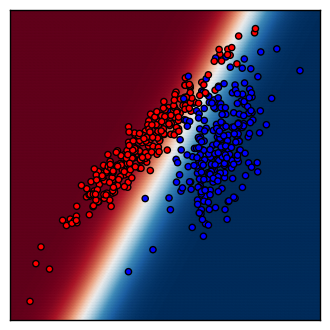

In [3]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=345678)
X, y = X.astype(np.float32), y.astype(np.uint8)

def my_model(X, y):
    y = tf.reshape(y, [-1, 1])
    logit = slim.fully_connected(X, 1, activation_fn=None, scope='fc')
    prob = tf.sigmoid(logit)
    prob = tf.reshape(prob, [-1])
    loss = slim.losses.sigmoid_cross_entropy(logit, y)
    train_op = slim.optimize_loss(loss, slim.get_global_step(), learning_rate=0.1, optimizer='SGD')

    return {'class': tf.cast(tf.round(prob), tf.uint8), 'prob': prob}, loss, train_op

class MyMonitor(learn.monitors.BaseMonitor):

    def begin(self, max_steps):
        self.figure = plt.figure(figsize=(4, 4))
        self.cm = plt.cm.RdBu
        self.cm_scatter = ListedColormap(['#FF0000', '#0000FF'])

        self.x_min, self.x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        self.y_min, self.y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(self.x_min, self.x_max, .02), np.arange(self.y_min, self.y_max, .02))
        self.xx, self.yy = self.xx.astype(np.float32), self.yy.astype(np.float32)
        self.grid = np.c_[self.xx.ravel(), self.yy.ravel()]

    def step_begin(self, step):
        return ['fc/weights', 'fc/biases']

    def step_end(self, step, outputs):
        self.figure.clf()
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.xticks(())
        plt.yticks(())

        w = outputs['fc/weights']
        b = outputs['fc/biases']
        logit = self.grid.dot(w) + b
        logit = logit.reshape(self.xx.shape)
        z = self.sigmoid(logit)
        plt.scatter(self.xx.ravel(), self.yy.ravel(), c=z, cmap=self.cm, marker='.', alpha=0.8, linewidths=0.01)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=self.cm_scatter)

        self.figure.canvas.draw()

    def end(self):
        pass

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

classifier = learn.Estimator(model_fn=my_model, model_dir='/tmp/my_model/perceptron')
classifier.fit(x=X, y=y, steps=500, batch_size=128, monitors=[MyMonitor()])

## (多クラス)ロジスティック回帰

- 2クラスロジスティック回帰の活性化関数をシグモイド関数からソフトマックス関数に変更すると、多クラスロジスティック回帰になる
- ソフトマックス関数はシグモイド関数の親戚みたいなもので、複数の出力を返す。各出力はやはり 0 < p < 1 の確率で全てのクラスの出力を合計すると1になる

Estimator(params=None)

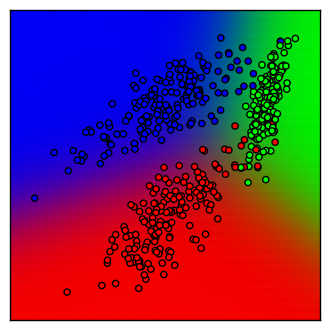

In [4]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

n_class = 3
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_classes=n_class, n_clusters_per_class=1, random_state=234567)
X, y = X.astype(np.float32), y.astype(np.uint8)

def my_model(X, y):
    y = slim.one_hot_encoding(y, n_class)
    logit = slim.fully_connected(X, n_class, activation_fn=None, scope='fc')
    prob = slim.softmax(logit)
    loss = slim.losses.softmax_cross_entropy(logit, y)
    train_op = slim.optimize_loss(loss, slim.get_global_step(), learning_rate=0.1, optimizer='SGD')

    return {'class': tf.argmax(prob, 1), 'prob': prob}, loss, train_op

class MyMonitor(learn.monitors.BaseMonitor):

    def begin(self, max_steps):
        self.figure = plt.figure(figsize=(4, 4))
        self.cm_scatter = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

        self.x_min, self.x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        self.y_min, self.y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(self.x_min, self.x_max, .02), np.arange(self.y_min, self.y_max, .02))
        self.xx, self.yy = self.xx.astype(np.float32), self.yy.astype(np.float32)
        self.grid = np.c_[self.xx.ravel(), self.yy.ravel()]

    def end(self):
        pass

    def step_begin(self, step):
        return ['fc/weights', 'fc/biases']

    def step_end(self, step, outputs):
        self.figure.clf()
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.xticks(())
        plt.yticks(())

        w = outputs['fc/weights']
        b = outputs['fc/biases']
        logit = self.grid.dot(w) + b
        logit = logit.reshape([-1, n_class])
        prob = self.softmax(logit)

        plt.scatter(self.xx.ravel(), self.yy.ravel(), c=prob, marker='.', alpha=0.8, linewidths=0.01)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=self.cm_scatter)
        self.figure.canvas.draw()

    def softmax(self, x):
        e = np.exp(x)
        sum = e.sum(axis=1)
        sum = np.repeat(sum.reshape([-1, 1]), 3, axis=1)
        return e / sum

classifier = learn.Estimator(model_fn=my_model, model_dir='/tmp/my_model/logistic_regression')
classifier.fit(x=X, y=y, steps=100, batch_size=128, monitors=[MyMonitor()]) 

## 多層パーセプトロン

- 単純パーセプトロンやロジスティック回帰の入力と出力の間に中間層を加えたもの
- 中間層が加わることで非線形・複雑な問題に対応できるようになった

Step 00200 - loss: 0.61443
Step 00400 - loss: 0.49104
Step 00600 - loss: 0.54769
Step 00800 - loss: 0.45616
Step 01000 - loss: 0.71612
Step 01200 - loss: 0.31246
Step 01400 - loss: 0.29622
Step 01600 - loss: 0.33148
Step 01800 - loss: 0.27309
Step 02000 - loss: 0.22412
Step 02200 - loss: 0.14686
Step 02400 - loss: 0.17077
Step 02600 - loss: 0.07663
Step 02800 - loss: 0.21062
Step 03000 - loss: 0.04181
Step 03200 - loss: 0.03813
Step 03400 - loss: 0.19312
Step 03600 - loss: 0.03399
Step 03800 - loss: 0.02082
Step 04000 - loss: 0.02772
Step 04200 - loss: 0.05482
Step 04400 - loss: 0.01448
Step 04600 - loss: 0.06783
Step 04800 - loss: 0.03949
Step 05000 - loss: 0.04090
Step 05200 - loss: 0.03557
Step 05400 - loss: 0.05750
Step 05600 - loss: 0.02949
Step 05800 - loss: 0.08082
Step 06000 - loss: 0.00263
Step 06200 - loss: 0.05767
Step 06400 - loss: 0.01257
Step 06600 - loss: 0.06410
Step 06800 - loss: 0.00176
Step 07000 - loss: 0.01039
Step 07200 - loss: 0.00383
Step 07400 - loss: 0.00602
S

Estimator(params=None)

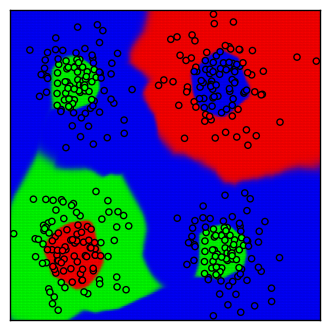

In [5]:
from sklearn.datasets import make_gaussian_quantiles
from matplotlib.colors import ListedColormap

n_class = 3
n_cluster = 2
n_step = 20000
tf.set_random_seed(0)

for row, mean_x in enumerate(np.linspace(-2.0, 2.0, n_cluster)):
    for col, mean_y in enumerate(np.linspace(-2.0, 2.0, n_cluster)):
        step = row + col
        new_X, new_y = make_gaussian_quantiles(mean=(mean_x, mean_y), cov=0.4, n_samples=100, n_features=2, n_classes=2, random_state=step)
        new_y += step
        new_y = np.mod(new_y, n_class)
        if step == 0:
            X, y = new_X, new_y
        else:
            X, y = np.concatenate((X, new_X)), np.concatenate((y, new_y))
X = X.astype(np.float32)

def my_model(x, y):
    y = slim.one_hot_encoding(y, n_class)
    with tf.name_scope(None, 'MyOp', [x]) as scope:
        net = slim.stack(x, slim.fully_connected, [30 for _ in range(5)], activation_fn=tf.nn.relu, scope=scope)
        logit = slim.fully_connected(net, n_class, activation_fn=None, scope=scope)
    prob = slim.softmax(logit, scope='prob')
    loss = slim.losses.softmax_cross_entropy(logit, y, scope='loss')
    learning_rate = tf.train.exponential_decay(0.1, slim.get_global_step(), 4, 0.9994, staircase=True)
    train_op = slim.optimize_loss(loss, slim.get_global_step(), learning_rate=learning_rate, optimizer='SGD')

    return {'class': tf.cast(tf.argmax(prob, 1), tf.uint8), 'prob': prob}, loss, train_op

class MyMonitor(learn.monitors.EveryN):

    def begin(self, max_steps):
        super(MyMonitor, self).begin(max_steps)

        self.variables = [t.name for t in slim.get_variables(scope='MyOp')]

        self.figure = plt.figure(figsize=(4, 4))
        self.cm_scatter = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

        self.x_min, self.x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
        self.y_min, self.y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
        self.linewidth = min(self.x_max - self.x_min, self.y_max - self.y_min) / 200
        self.xx, self.yy = np.meshgrid(np.arange(self.x_min, self.x_max, self.linewidth), np.arange(self.y_min, self.y_max, self.linewidth))
        self.xx, self.yy = self.xx.astype(np.float32), self.yy.astype(np.float32)
        self.grid = np.c_[self.xx.ravel(), self.yy.ravel()]

    def end(self):
        super(MyMonitor, self).end()

    def every_n_step_begin(self, step):
        return self.variables + ['loss/value:0']

    def every_n_step_end(self, step, outputs):
        print('Step {0:0>5} - loss: {1:.5f}'.format(step, outputs['loss/value:0']))

        self.figure.clf()
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.xticks(())
        plt.yticks(())

        logit = self.grid
        n_layer = len(self.variables) // 2
        for i in range(n_layer):
            w, b = self.variables[i * 2], self.variables[i * 2 + 1]
            logit = logit.dot(outputs[w]) + outputs[b]
            if i < n_layer - 1:
                logit = self.relu(logit)
            else:
                prob = self.softmax(logit)
        prob = prob.reshape([-1, 3])

        plt.scatter(self.xx.ravel(), self.yy.ravel(), c=prob, marker='.', alpha=0.8, linewidths=self.linewidth)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=self.cm_scatter)
        self.figure.canvas.draw()

    def relu(self, x):
        x[x < 0] = 0
        return x

    def softmax(self, x):
        e = np.nan_to_num(np.exp(x))
        sum = e.sum(axis=1)
        sum = np.repeat(sum.reshape([-1, 1]), 3, axis=1)
        return e / sum

classifier = learn.Estimator(model_fn=my_model, model_dir='/tmp/my_model/multi_layer_perceptron')
classifier.fit(x=X, y=y, steps=n_step, batch_size=128, monitors=[MyMonitor(every_n_steps=n_step // 100, first_n_steps=0)] + learn.monitors.get_default_monitors(save_summary_steps=n_step // 100))